In [107]:
import numpy as np
import sys
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import networkx as nx

global G1,G2,G3


def init_array(size):
    A = np.random.randint(100, size=(9, 9))
    np.fill_diagonal(A, 0)
    A=np.triu(A) + np.tril(A.T)
    return A


def TSP(Graph,S,destination):
    if (len(S)==2):
        lS=list(S)
        return list([(1,destination)]), Graph[lS[0],lS[1]]
    else:
        min_dist=999
        min_node=-1
        min_way=list()
        for _,node in enumerate(S):
            if (node != 1 and node != destination):
                w,d=TSP(Graph,S.difference(set([node])),node)
                d+=Graph[node-1,destination-1]
                if d<min_dist:
                    min_dist=d
                    min_node=node
                    min_way=w
                    min_way.append((node,destination))
        return min_way,min_dist
def getTSP(G):
    nodecount=len(G[0])
    return TSP(G,set(range(1,nodecount)),nodecount)

G1=init_array(9)
G2=init_array(10)
G3=init_array(11)


In [108]:
print(getTSP(G1))

([(1, 3), (3, 7), (7, 6), (6, 4), (4, 8), (8, 5), (5, 9)], 168)


In [67]:
k=list([(1,2)])
print(k)

[(1, 2)]


In [73]:
print(np.version.full_version)


1.16.4


In [74]:
import pkg_resources
from subprocess import call

packages = [dist.project_name for dist in pkg_resources.working_set]
call("pip install --upgrade " + ' '.join(packages), shell=True)

2

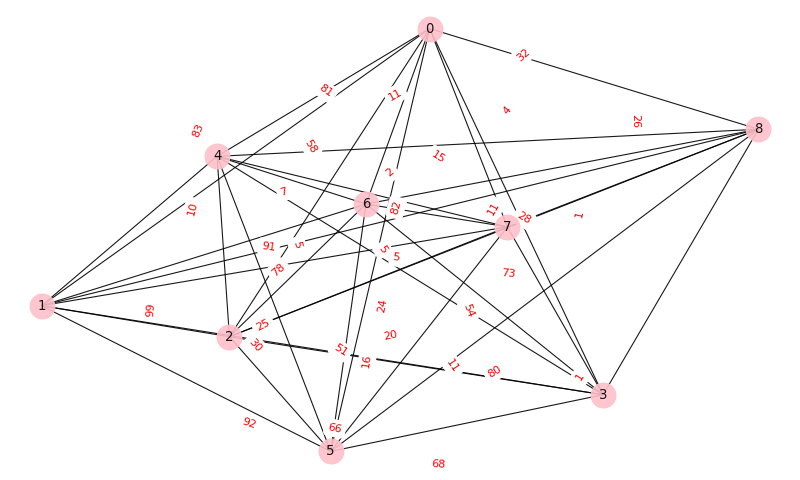

In [26]:
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
%config InlineBackend.rc = {'font.size': 10, 'figure.figsize': (10.0, 6.0), 'figure.facecolor': (1, 1, 1, 0), 'figure.subplot.bottom': 0.125, 'figure.edgecolor': (1, 1, 1, 0), 'figure.dpi': 72}

import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
G = nx.from_numpy_array(G1)
G.edges(data=True)
G.remove_edge(1,2)
G.add_edge(1,2,color='red',weight=2)

pos = nx.spring_layout(G)
e_labels={}
for e in G.edges():
    e_labels[e]=G1[e[0],e[1]]
nx.draw(G,node_size=500,node_color='pink',alpha=0.9,labels={node:node for node in G.nodes()})
nx.draw_networkx_edge_labels(G,pos,edge_labels=e_labels,font_color='red')    
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

plt.show()

In [16]:
import plotly.graph_objects as go



AttributeError: 'EdgeView' object has no attribute 'next'

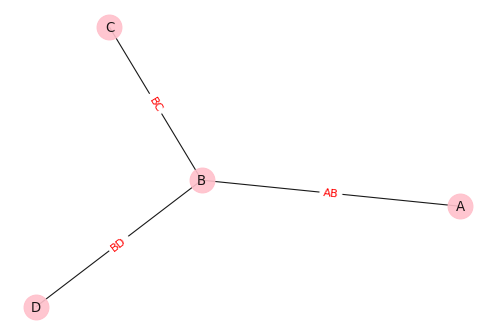

In [90]:
for 
edges=[['A','B'],['B','C'],['B','D']]
G=nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
plt.figure()    
nx.draw(G,pos,edge_color='black',width=1,linewidths=1,\
node_size=500,node_color='pink',alpha=0.9,\
labels={node:node for node in G.nodes()})
nx.draw_networkx_edge_labels(G,pos,edge_labels={('A','B'):'AB',('B','C'):'BC',('B','D'):'BD'},font_color='red')
plt.axis('off')
plt.show()

In [34]:
pos = nx.spring_layout(G)
print(pos)

{0: array([0.23381748, 0.68255002]), 1: array([-0.88006713, -0.16779894]), 2: array([-0.48461689, -0.11464186]), 3: array([ 0.42860409, -0.49396444]), 4: array([-0.33832643,  0.4159952 ]), 5: array([-0.25241636, -0.58679546]), 6: array([-0.00737773, -0.00608525]), 7: array([0.30038296, 0.19258719]), 8: array([1.        , 0.07815355])}


In [124]:
import plotly.graph_objects as go

import networkx as nx

way,way_len=getTSP(G1)

G = nx.from_numpy_array(G1)
G.edges(data=True)
pos = nx.circular_layout(G)


edge_label_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    textposition='middle center',
    mode='markers+text',
    hoverinfo='none',
    marker=go.scatter.Marker(
        opacity=0
    ),
    textfont=dict(size=9, color='blue')
)


edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)
    
    #invisible node at middle of edges to place edge labels
    edge_label_trace['x']+=((x0+x1)/2,)
    edge_label_trace['y']+=((y0+y1)/2,)
    edge_label_trace['text']+=(G1[edge[0]][edge[1]],)
        
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

way_x = []
way_y = []
for w in way:
    x0, y0 = pos[w[0]-1]
    x1, y1 = pos[w[1]-1]
    way_x.append(x0)
    way_x.append(x1)
    way_x.append(None)
    way_y.append(y0)
    way_y.append(y1)
    way_y.append(None)
    
way_trace = go.Scatter(
    x=way_x, y=way_y,
    line=dict(width=2, color='#F00'),
    hoverinfo='none',
    mode='lines')


node_x = []
node_y = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    hoverinfo='none',
    textposition='middle center',
    marker=dict(
        showscale=False,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='Earth',
        reversescale=True,
        color='#FFF',
        size=25,
        line_width=2))
node_trace.text = [x+1 for x in list(G.nodes())]



fig = go.Figure(data=[edge_trace, node_trace,edge_label_trace,way_trace],
             layout=go.Layout(
                title='Traveling Salesman exact Solution',
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text=("Traveling Salesman result : %s, Length=%d" % (way,way_len)),
                    showarrow=False,
                    xref="paper", yref="paper",
                    x=0.005, y=-0.002 ) ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                )
fig.show()

In [98]:
way_trace

Scatter({
    'hoverinfo': 'none', 'line': {'color': '#F00', 'width': 2}, 'mode': 'lines', 'x': [], 'y': []
})

In [129]:
class a:
    kaka="ba"
    def __init__(self):
        self.pipi="berk"
        
v1=a()
a.kaka="gg"
v2=a()

print(v1.kaka)
print(v2.kaka)
print (a.kaka)

gg
gg
gg


In [150]:
a=np.zeros(G1.shape)+0.001
print(a)

[[0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
 [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
 [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
 [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
 [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
 [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
 [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
 [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
 [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]]


In [191]:
print(np.array([1,2])==np.array([1,1]))

[ True False]


In [198]:
x= 1 if 0==1 else 2

2